## About Calibration

* We all know that we can predict classes with probability in classification.
* The return probability of the predicted classes can be overconfident or underconfident. Well calibrated classifiers can return probabilities that also serve as the confidence level of the prediction.
* Also because of the biased probability some classifiers can return, calibration also serve as a postprocessing method after classification.

### Part 1 - Calibration Curve

First of all, let's plot calibration curve that shows how each classifier predict the probabilities.

* Reference: 
    * Compare Classifier Calibration: http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py
    * Probability Calibration Curves: http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

np.random.seed(410)
%matplotlib inline

In [4]:
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                            n_informative=2, n_redundant=2)  # 2 redundant features, so they are not independent

In [8]:
print(X[7:9])
print
print(y[7:9])

[[ 0.01445033 -0.92107234 -0.46354429  0.3630414  -1.1918896   0.16138048
   0.67197852  0.42555066  0.70376169 -1.51245371  0.94378923  0.08117032
   0.1521533  -1.82155082  0.22509341  0.83438138  0.28140544  0.32033946
   1.29760252  0.82840844]
 [-0.88497512  0.77708684 -1.64687127  1.33425731 -1.0177187   1.48156691
   0.60784102  0.67662979 -0.50378369 -0.94822212 -1.68994271  0.74567437
  -0.09425681 -1.2472162  -1.66713199  0.28205556  0.93184424  0.94909809
   1.70828695 -0.23390067]]

[0 0]


In [9]:
train_samples = 70000  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

In [10]:
# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)

('Support Vector Classification', array([-0.31859105, -0.55523149,  1.34940185, -0.16591174, -0.93154359,
       -0.23985766]))


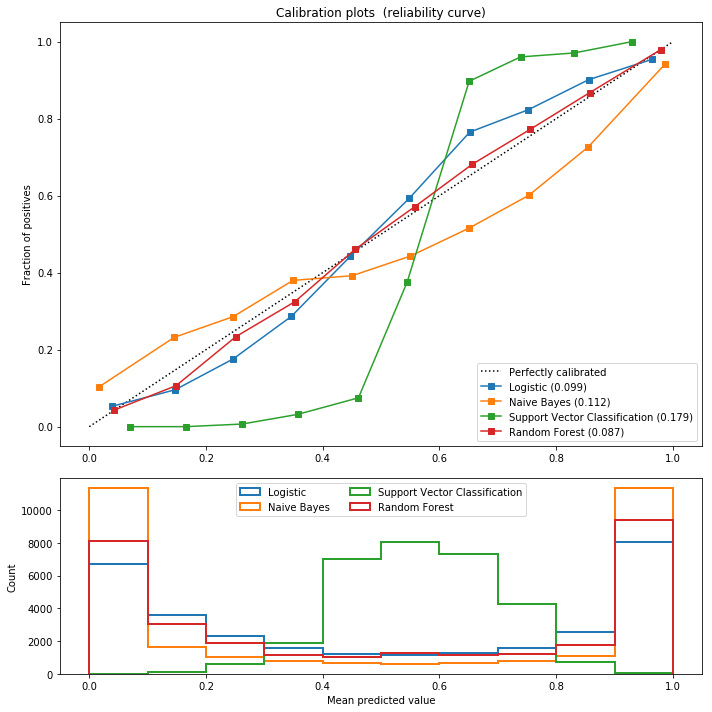

In [15]:
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # SVM uses decision function that returns numerical values, we need to normlalize these values into [0,1]
        prob_pos = clf.decision_function(X_test)
        print(name, prob_pos[4:10])  # TEST
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())  # brier score for the classification

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % (name, clf_score))
    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

### Part 1 Summary

* As you can see, I used 70000 samples as the training data, and therefore the plots are different from the references.
* SVM is showing sigmoid shape, this is the sign of underconfident.
  * If you will see transposed-sigmoid shape, that's the typical sign of overcofident.
* I'm using Brier score here to measure how accurate the predictions are and also to show well the predictions calibrated.
  * Lower Brier score, the higher accuracy, the better calibration of the prediction.
  * Random Forest gets the lowest Brier score, much better than the reference results. I think this is because when it gets enough sample, the bias caused by the variance has reduced. >> So maybe ensembling methods can be a good choice for generated better calibrated predictions.
  * According to the reference, Logistcs regression tend to get well calibrated results, because it optimizes the logloss directly.
* If we check the second plot, we can see some classifiers tend to push the predicted probabilities toward 0 or 1 while some tend to push the values away from 0 or 1.
  * GaussianNaiveBayes tends to push probabilities to 0 or 1 (note the counts in the histograms). This is mainly because it makes the assumption that features are conditionally independent given the class, which is not the case in this dataset which contains 2 redundant features.
  * Support Vector Classification (SVC) shows an even more sigmoid curve as the RandomForestClassifier, which is typical for maximum-margin methods (compare Niculescu-Mizil and Caruana [1]), which focus on hard samples that are close to the decision boundary (the support vectors).